### Data Preparation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random
import torch
import torchvision
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch import optim
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Label =  blazer


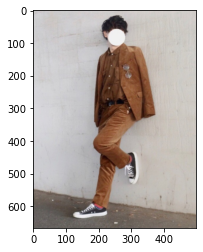

Label =  cardigan


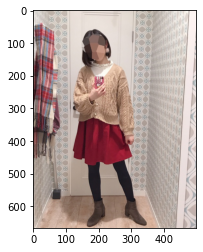

Label =  coat


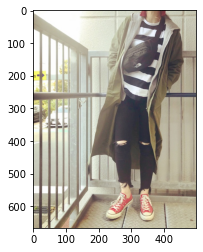

Label =  jacket


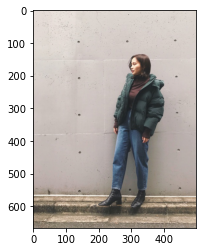

In [2]:
random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("photos/train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 1):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

### Q1
(5%) 列出train, valid, test的總照片數，以及各類別的照片數與比率。在還沒進行模型訓練與評估前，你認為各類別相對的準確率的大小關係為何?

In [3]:
train_len = []
valid_len = []
test_len = []

for i in range(4):
    # train
    train_folds = os.listdir("photos/train/" + labels[i])
    train_len.append(len(train_folds))
    # valid
    valid_folds = os.listdir("photos/valid/" + labels[i])
    valid_len.append(len(valid_folds))
    # test
    test_folds = os.listdir("photos/test/" + labels[i])
    test_len.append(len(test_folds))

In [4]:
num = [0, 0, 0]
type_num = [0, 0, 0, 0]

for i in range(4):
    num[0] += train_len[i]
    num[1] += valid_len[i]
    num[2] += test_len[i]
    type_num[i] = train_len[i] + valid_len[i] + test_len[i]
    

print("Total number of pictures in training dataset:", num[0])
print("Total number of pictures in validing dataset:", num[1])
print("Total number of pictures in testing dataset:", num[2])
print("=======================================================")
for i in range(4):
    print(labels[i], "percentage: {:.2%}".format(type_num[i]/(num[0]+num[1]+num[2])), ", with the number of", type_num[i])

Total number of pictures in training dataset: 1041
Total number of pictures in validing dataset: 105
Total number of pictures in testing dataset: 146
blazer percentage: 8.75% , with the number of 113
cardigan percentage: 24.38% , with the number of 315
coat percentage: 28.33% , with the number of 366
jacket percentage: 38.54% , with the number of 498


### Q1 Conclusion
train, valid, test的比例約為8:1:1，為常用的切法。而觀察類別時，依照數量多寡推測準確度大小依序為 jacket > coat > cardigan > blazer。

### Q2
(35%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。使用train資料訓練模型，以valid資料決定Early Stopping的Epoch。Early Stopping的Patient參數設為20 Epochs。Batch size設為32。每一個Epoch計算一次Valid Loss，並記錄Valid Loss最低的模型。模型訓練最多200個Epochs。使用最佳模型在test資料計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的Valid Loss。

由於圖片的解析度較高，模型訓練前須將解析度調整(Resize)成較短邊為256像素的照片，然後隨機取大小為224x224的影像。接著隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度，並依照Pretrained ResNet的要求調整RGB的均數與標準差。
測試資料(Valid and Test)亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

得到Per-Class Accuracy之後，請討論與Q1預期的差異與可能原因。

提示: 
* Pytorch Resnet pretrained model的說明請見 <https://pytorch.org/hub/pytorch_vision_resnet/>
* 本題的Test Accuracy應高於78%。

Prepare dataset and dataloader

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(root="photos/train", transform=train_transform)
valid_dataset = datasets.ImageFolder(root="photos/valid", transform=valid_transform)
test_dataset = datasets.ImageFolder(root="photos/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train

In [7]:
def train(model, device, epochs, optimizer, loss_function, patience, train_loader, valid_loader, prints=1):
    
    stop_train = 0
    min_valid_loss = np.inf
    current_loss = 0
    count = 0

    for epoch in range(1, epochs+1):
        if prints == 1:
            print('running epoch: {}, count: {}'.format(epoch, count))
        model.train()

        for i, data in enumerate(train_loader, 1):
            
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Early stopping
        valid_loss = validation(model, device, valid_loader, loss_function)
        if prints == 1:
            print("current valid loss: %.4f" % valid_loss)
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            count = 0
        else:
            count += 1
        if count == patience:
            break
    if prints == 1:
        print('==================== Training Finished ====================')

    return model

valid

In [8]:
def validation(model, device, valid_loader, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for data in valid_loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(valid_loader)

test

In [9]:
def test(model, device, test_loader, loss_function):
    
    total = 0
    correct = 0
    y_pred=[]
    y_true=[]
    
    # Settings
    model.eval()
    
    # Test validation data
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds==labels).sum().item()
            y_pred.extend(preds.view(-1).detach().cpu().numpy())       
            y_true.extend(labels.view(-1).detach().cpu().numpy())
            
    acc = correct / total
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm.diagonal()/cm.sum(axis=0)
    labels = ['Blazer', 'Cardigan', 'Coat', 'Jacket']
    
    print("Accuracy: {:.2%}".format(acc))
    print("Confusion Matrix:\n", cm)
    print("Per-class Accuracy:")
    for i in range(4):
        print(labels[i], "Accuracy: {:.2%}".format(per_class_accuracy[i]))

Setting up and run

SGD

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_SGD = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_SGD.fc = torch.nn.Linear(model_SGD.fc.in_features, 4)
model_SGD.eval()
model_SGD.to(device)

optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=0.001, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()
epochs = 200
patience = 20

model_SGD = train(model_SGD, device, epochs, optimizer_SGD, loss_function, patience, train_loader, valid_loader)

Using cuda device


Using cache found in C:\Users\asdfg/.cache\torch\hub\pytorch_vision_v0.10.0


running epoch: 1, count: 0
current valid loss: 1.2030
running epoch: 2, count: 0
current valid loss: 1.0433
running epoch: 3, count: 0
current valid loss: 0.9835
running epoch: 4, count: 0
current valid loss: 0.9041
running epoch: 5, count: 0
current valid loss: 0.8188
running epoch: 6, count: 0
current valid loss: 0.8077
running epoch: 7, count: 0
current valid loss: 0.7305
running epoch: 8, count: 0
current valid loss: 0.6885
running epoch: 9, count: 0
current valid loss: 0.5805
running epoch: 10, count: 0
current valid loss: 0.5853
running epoch: 11, count: 1
current valid loss: 0.7321
running epoch: 12, count: 2
current valid loss: 0.6199
running epoch: 13, count: 3
current valid loss: 0.6060
running epoch: 14, count: 4
current valid loss: 0.5366
running epoch: 15, count: 0
current valid loss: 0.5385
running epoch: 16, count: 1
current valid loss: 0.6252
running epoch: 17, count: 2
current valid loss: 0.7617
running epoch: 18, count: 3
current valid loss: 0.6115
running epoch: 19, 

In [11]:
test(model_SGD, device, test_loader, loss_function)

Accuracy: 81.51%
Confusion Matrix:
 [[ 6  0  1  2]
 [ 0 26  7  9]
 [ 2  0 39  2]
 [ 1  1  2 48]]
Per-class Accuracy:
Blazer Accuracy: 66.67%
Cardigan Accuracy: 96.30%
Coat Accuracy: 79.59%
Jacket Accuracy: 78.69%


ADAM

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_ADAM = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_ADAM.fc = torch.nn.Linear(model_ADAM.fc.in_features, 4)
model_ADAM.eval()
model_ADAM.to(device)

optimizer_ADAM = torch.optim.Adam(model_ADAM.fc.parameters(), lr=0.0001)
loss_function = torch.nn.CrossEntropyLoss()
epochs = 200
patience = 20

model_ADAM = train(model_ADAM, device, epochs, optimizer_ADAM, loss_function, patience, train_loader, valid_loader)

Using cuda device


Using cache found in C:\Users\asdfg/.cache\torch\hub\pytorch_vision_v0.10.0


running epoch: 1, count: 0
current valid loss: 1.2289
running epoch: 2, count: 0
current valid loss: 1.2145
running epoch: 3, count: 0
current valid loss: 1.1897
running epoch: 4, count: 0
current valid loss: 1.1794
running epoch: 5, count: 0
current valid loss: 1.1624
running epoch: 6, count: 0
current valid loss: 1.1386
running epoch: 7, count: 0
current valid loss: 1.1229
running epoch: 8, count: 0
current valid loss: 1.1151
running epoch: 9, count: 0
current valid loss: 1.1100
running epoch: 10, count: 0
current valid loss: 1.0903
running epoch: 11, count: 0
current valid loss: 1.0812
running epoch: 12, count: 0
current valid loss: 1.0694
running epoch: 13, count: 0
current valid loss: 1.0681
running epoch: 14, count: 0
current valid loss: 1.0532
running epoch: 15, count: 0
current valid loss: 1.0573
running epoch: 16, count: 1
current valid loss: 1.0457
running epoch: 17, count: 0
current valid loss: 1.0470
running epoch: 18, count: 1
current valid loss: 1.0400
running epoch: 19, 

In [13]:
test(model_ADAM, device, test_loader, loss_function)

Accuracy: 60.96%
Confusion Matrix:
 [[ 5  0  0  4]
 [ 0 28  4 10]
 [ 1  8 19 15]
 [ 3 10  2 37]]
Per-class Accuracy:
Blazer Accuracy: 55.56%
Cardigan Accuracy: 60.87%
Coat Accuracy: 76.00%
Jacket Accuracy: 56.06%


回顧一開始的預測準確度：jacket > coat > cardigan > blazer，實際上:
* SGD的預測排名為: cardigan > coat > jacket > blazer
* Adam的預測排名為: coat > cardigan > jacket > blazer

可以發現跟預測的排名有出入，可以知道其實實際訓練成效與資料量不成正比，有可能是本身圖片就比較難分類，資料多也沒用。

### Q3
(30%) 使用Resnet50建構圖片分類模型。將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求。除了最後一層以外，使用torchvision提供的pretrained weights (`torchvision.models.resnet50(pretrained=True)`)初始化模型權重。模型訓練時固定除了最後一層以外的其他權重。也就是說，模型訓練只會調整最後一層Fully Connected Layer。圖片前處理與前題一致。

使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。

SGD

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_SGD2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# 固定除了最後一層以外的其他權重
for param in model_SGD2.parameters():
    param.requires_grid = False

model_SGD2.fc = torch.nn.Linear(model_SGD2.fc.in_features, 4)
model_SGD2.eval()
model_SGD2.to(device)

optimizer_SGD2 = torch.optim.SGD(model_SGD2.parameters(), lr=0.001, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()
epochs = 200
patience = 20

model_SGD2 = train(model_SGD2, device, epochs, optimizer_SGD2, loss_function, patience, train_loader, valid_loader)

Using cuda device


Using cache found in C:\Users\asdfg/.cache\torch\hub\pytorch_vision_v0.10.0


running epoch: 1, count: 0
current valid loss: 1.1090
running epoch: 2, count: 0
current valid loss: 1.0048
running epoch: 3, count: 0
current valid loss: 1.0399
running epoch: 4, count: 1
current valid loss: 0.8492
running epoch: 5, count: 0
current valid loss: 0.7530
running epoch: 6, count: 0
current valid loss: 0.7005
running epoch: 7, count: 0
current valid loss: 0.6956
running epoch: 8, count: 0
current valid loss: 0.6776
running epoch: 9, count: 0
current valid loss: 0.6004
running epoch: 10, count: 0
current valid loss: 0.5921
running epoch: 11, count: 0
current valid loss: 0.6791
running epoch: 12, count: 1
current valid loss: 0.7403
running epoch: 13, count: 2
current valid loss: 0.6041
running epoch: 14, count: 3
current valid loss: 0.7298
running epoch: 15, count: 4
current valid loss: 0.6819
running epoch: 16, count: 5
current valid loss: 0.6579
running epoch: 17, count: 6
current valid loss: 0.6569
running epoch: 18, count: 7
current valid loss: 0.5636
running epoch: 19, 

In [11]:
test(model_SGD2, device, test_loader, loss_function)

Accuracy: 76.71%
Confusion Matrix:
 [[ 6  0  1  2]
 [ 0 26  3 13]
 [ 1  2 34  6]
 [ 1  2  3 46]]
Per-class Accuracy:
Blazer Accuracy: 75.00%
Cardigan Accuracy: 86.67%
Coat Accuracy: 82.93%
Jacket Accuracy: 68.66%


ADAM

In [12]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_ADAM2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# 固定除了最後一層以外的其他權重
for param in model_ADAM2.parameters():
    param.requires_grid = False

model_ADAM2.fc = torch.nn.Linear(model_ADAM2.fc.in_features, 4)
model_ADAM2.eval()
model_ADAM2.to(device)

optimizer_ADAM2 = torch.optim.Adam(model_ADAM2.fc.parameters(), lr=0.0001)
loss_function = torch.nn.CrossEntropyLoss()
epochs = 200
patience = 20

model_ADAM2 = train(model_ADAM2, device, epochs, optimizer_ADAM2, loss_function, patience, train_loader, valid_loader)

Using cuda device


Using cache found in C:\Users\asdfg/.cache\torch\hub\pytorch_vision_v0.10.0


running epoch: 1, count: 0
current valid loss: 1.2289
running epoch: 2, count: 0
current valid loss: 1.2459
running epoch: 3, count: 1
current valid loss: 1.2007
running epoch: 4, count: 0
current valid loss: 1.1722
running epoch: 5, count: 0
current valid loss: 1.1444
running epoch: 6, count: 0
current valid loss: 1.1381
running epoch: 7, count: 0
current valid loss: 1.1334
running epoch: 8, count: 0
current valid loss: 1.1074
running epoch: 9, count: 0
current valid loss: 1.1238
running epoch: 10, count: 1
current valid loss: 1.0898
running epoch: 11, count: 0
current valid loss: 1.0760
running epoch: 12, count: 0
current valid loss: 1.0778
running epoch: 13, count: 1
current valid loss: 1.0525
running epoch: 14, count: 0
current valid loss: 1.0560
running epoch: 15, count: 1
current valid loss: 1.0397
running epoch: 16, count: 0
current valid loss: 1.0366
running epoch: 17, count: 0
current valid loss: 1.0408
running epoch: 18, count: 1
current valid loss: 1.0216
running epoch: 19, 

In [13]:
test(model_ADAM2, device, test_loader, loss_function)

Accuracy: 60.96%
Confusion Matrix:
 [[ 5  0  1  3]
 [ 0 24  7 11]
 [ 1  6 24 12]
 [ 3  8  5 36]]
Per-class Accuracy:
Blazer Accuracy: 55.56%
Cardigan Accuracy: 63.16%
Coat Accuracy: 64.86%
Jacket Accuracy: 58.06%


相較於Q2的結果，Q3的結果較差，以下將列出排名順序
* SGD的預測排名為: cardigan > coat > blazer > jacket
* Adam的預測排名為: coat > cardigan > jacket > blazer

可以發現SGD的順序與Q2有調換，blazer和jacket的排名對調。

### Q4
(20%) 使用Resnet50建構圖片分類模型。將最後一層的fully connected layer輸出維度改成4以符合本題任務需求。圖片前處理與前題一致。不使用預訓練權重初始化模型。使用train訓練模型，以valid決定early stopping的epoch。Early stopping的patient參數為20 epochs。Batch size設為32。紀錄valid loss最低的模型，並在test中計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的valid loss。

SGD

In [14]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_SGD3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
model_SGD3.fc = torch.nn.Linear(model_SGD3.fc.in_features, 4)
model_SGD3.eval()
model_SGD3.to(device)

optimizer_SGD3 = torch.optim.SGD(model_SGD3.parameters(), lr=0.001, momentum=0.9)
loss_function = torch.nn.CrossEntropyLoss()
epochs = 200
patience = 20

model_SGD3 = train(model_SGD3, device, epochs, optimizer_SGD3, loss_function, patience, train_loader, valid_loader)

Using cuda device


Using cache found in C:\Users\asdfg/.cache\torch\hub\pytorch_vision_v0.10.0


running epoch: 1, count: 0
current valid loss: 1.8661
running epoch: 2, count: 0
current valid loss: 1.5359
running epoch: 3, count: 0
current valid loss: 1.5536
running epoch: 4, count: 1
current valid loss: 1.4210
running epoch: 5, count: 0
current valid loss: 1.4303
running epoch: 6, count: 1
current valid loss: 1.5951
running epoch: 7, count: 2
current valid loss: 1.3622
running epoch: 8, count: 0
current valid loss: 1.4146
running epoch: 9, count: 1
current valid loss: 1.7754
running epoch: 10, count: 2
current valid loss: 1.2609
running epoch: 11, count: 0
current valid loss: 1.5040
running epoch: 12, count: 1
current valid loss: 1.3632
running epoch: 13, count: 2
current valid loss: 1.4282
running epoch: 14, count: 3
current valid loss: 1.5133
running epoch: 15, count: 4
current valid loss: 2.0878
running epoch: 16, count: 5
current valid loss: 1.9363
running epoch: 17, count: 6
current valid loss: 1.4169
running epoch: 18, count: 7
current valid loss: 1.4666
running epoch: 19, 

In [15]:
test(model_SGD3, device, test_loader, loss_function)

Accuracy: 39.73%
Confusion Matrix:
 [[ 0  3  0  6]
 [ 0 17  0 25]
 [ 0 13  1 29]
 [ 0 10  2 40]]
Per-class Accuracy:
Blazer Accuracy: nan%
Cardigan Accuracy: 39.53%
Coat Accuracy: 33.33%
Jacket Accuracy: 40.00%


ADAM

In [16]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model_ADAM3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
model_ADAM3.fc = torch.nn.Linear(model_ADAM3.fc.in_features, 4)
model_ADAM3.eval()
model_ADAM3.to(device)

optimizer_ADAM3 = torch.optim.Adam(model_ADAM3.fc.parameters(), lr=0.0001)
loss_function = torch.nn.CrossEntropyLoss()
epochs = 200
patience = 20

model_ADAM3 = train(model_ADAM3, device, epochs, optimizer_ADAM3, loss_function, patience, train_loader, valid_loader)

Using cuda device


Using cache found in C:\Users\asdfg/.cache\torch\hub\pytorch_vision_v0.10.0


running epoch: 1, count: 0
current valid loss: 1.2658
running epoch: 2, count: 0
current valid loss: 1.2477
running epoch: 3, count: 0
current valid loss: 1.2269
running epoch: 4, count: 0
current valid loss: 1.2691
running epoch: 5, count: 1
current valid loss: 1.2136
running epoch: 6, count: 0
current valid loss: 1.2568
running epoch: 7, count: 1
current valid loss: 1.2733
running epoch: 8, count: 2
current valid loss: 1.2812
running epoch: 9, count: 3
current valid loss: 1.2745
running epoch: 10, count: 4
current valid loss: 1.2457
running epoch: 11, count: 5
current valid loss: 1.2878
running epoch: 12, count: 6
current valid loss: 1.2707
running epoch: 13, count: 7
current valid loss: 1.2596
running epoch: 14, count: 8
current valid loss: 1.3441
running epoch: 15, count: 9
current valid loss: 1.2528
running epoch: 16, count: 10
current valid loss: 1.2720
running epoch: 17, count: 11
current valid loss: 1.2163
running epoch: 18, count: 12
current valid loss: 1.2279
running epoch: 1

In [17]:
test(model_ADAM3, device, test_loader, loss_function)

Accuracy: 36.30%
Confusion Matrix:
 [[ 0  0  1  8]
 [ 0  0  2 40]
 [ 0  0  1 42]
 [ 0  0  0 52]]
Per-class Accuracy:
Blazer Accuracy: nan%
Cardigan Accuracy: nan%
Coat Accuracy: 25.00%
Jacket Accuracy: 36.62%


可以發現假設在pretrain沒有的情況下，Accuracy就極度下降，不到4成。

### Q5
(10%) 統整併討論Q2-Q4的預測能力。說明你的觀察。

In [30]:
import pandas as pd

dict_of_lists = {
  "SGD": ['81.51%', '76.71%', '39.73%'],
  "Adam": ['60.96%', '60.96%', '36.30%']
}

print("Accuracy:")
pd.DataFrame(dict_of_lists).rename(index={0: "Q2", 1: "Q3", 2: "Q4"})

Accuracy:


,SGD,Adam
Q2,81.51%,60.96%
Q3,76.71%,60.96%
Q4,39.73%,36.30%


* 在這三種情況下，SGD的表現都比Adam好
* (Q2) predtrain+沒有固定權重的表現 > (Q3) predtrain+有固定除了最後一層以外的其他權重 > (Q4) 無Pretrain 
* 訓練資料最少的blazer的表現普遍較差，推測訓練資料不多表現不容易好，**但訓練資料多並不代表表現會好，否則準確度排行就會跟起初猜測一樣了。**